In [2]:
import sys
import os


os.makedirs('figures', exist_ok=True)
modules_to_remove = [key for key in sys.modules.keys() if key.startswith('src')]
for mod in modules_to_remove:
    del sys.modules[mod]

# Set path
if 'notebooks' in os.getcwd():
    sys.path.insert(0, '..')
    data_path = "../data/diabetes.csv"
else:
    data_path = "data/diabetes.csv"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import time
import warnings
warnings.filterwarnings('ignore')


In [3]:
from src.data_utils import load_diabetes_data
from src.models import train_logreg, train_random_forest
from src.fhe_context import FHEContext
from src.server import FHEServer
from src.client import FHEClient
from src.evaluation import evaluate_fhe_batch


In [4]:
df = pd.read_csv(data_path)

for col in ["Id", "id", "index"]:
    if col in df.columns:
        df = df.drop(columns=[col])

zero_invalid_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in zero_invalid_cols:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)
        df[col] = df[col].fillna(df[col].median())


# Separate features and target
X = df.drop(columns=["Outcome"]).values
y = df["Outcome"].values
feature_names = [c for c in df.columns if c != "Outcome"]

# Train-test split
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Features: {feature_names}")

  Training samples: 2214
  Test samples: 554
  Features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [5]:
logreg = train_logreg(X_train, y_train)
print(f" Logistic Regression trained")
print(f"  Coefficients: {logreg.coef_[0].round(3)}")
print(f"  Intercept: {logreg.intercept_[0]:.4f}")

rf = train_random_forest(X_train, y_train)
print(f"\n Random Forest trained ({rf.n_estimators} trees)")


 Logistic Regression trained
  Coefficients: [ 0.435  1.153 -0.021  0.077 -0.092  0.503  0.216  0.094]
  Intercept: -0.8751

 Random Forest trained (200 trees)


In [6]:
# Logistic Regression
y_pred_lr = logreg.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)

print(f"\nLogistic Regression Accuracy: {acc_lr:.4f}")
print(f"Confusion Matrix:\n{cm_lr}")

# Random Forest
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print(f"\nRandom Forest Accuracy: {acc_rf:.4f}")
print(f"Confusion Matrix:\n{cm_rf}")


Logistic Regression Accuracy: 0.7527
Confusion Matrix:
[[314  49]
 [ 88 103]]

Random Forest Accuracy: 0.9964
Confusion Matrix:
[[363   0]
 [  2 189]]


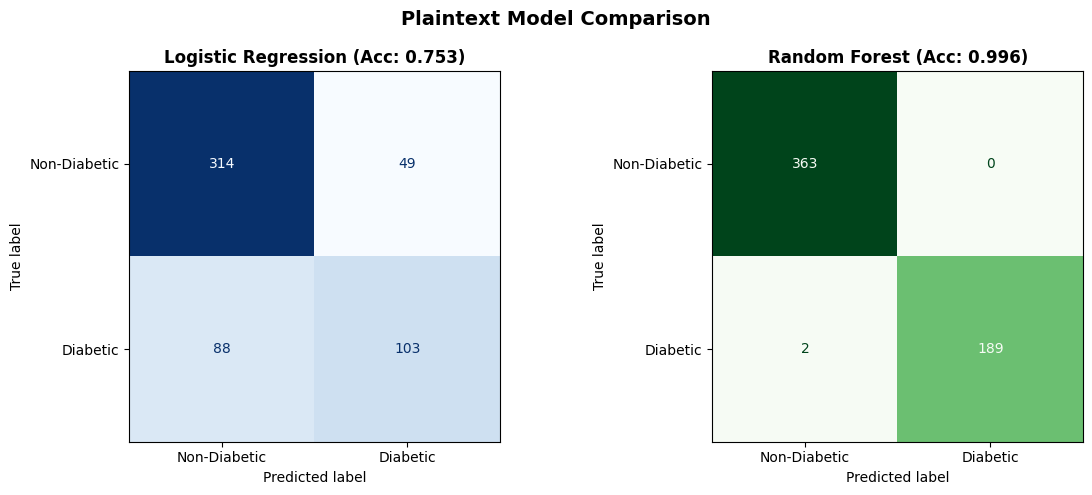

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(cm_lr, display_labels=["Non-Diabetic", "Diabetic"]).plot(
    ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title(f'Logistic Regression (Acc: {acc_lr:.3f})', fontweight='bold')

ConfusionMatrixDisplay(cm_rf, display_labels=["Non-Diabetic", "Diabetic"]).plot(
    ax=axes[1], cmap='Greens', colorbar=False)
axes[1].set_title(f'Random Forest (Acc: {acc_rf:.3f})', fontweight='bold')

plt.suptitle('Plaintext Model Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [8]:
import time

start_time = time.time()
fhe = FHEContext(n=16384, qi_sizes=[60, 40, 40, 60], scale=2**30)
keygen_time = time.time() - start_time

print(f"FHE initialized in {keygen_time:.2f} seconds")

FHE initialized in 0.78 seconds


In [9]:
print("Running FHE inference on 50 test samples")

start_time = time.time()
metrics_fhe = evaluate_fhe_batch(
    model=logreg,
    X_test=X_test,
    y_test=y_test,
    fhe_context=fhe,
    n_samples=50,
    random_state=42
)
total_time = time.time() - start_time

print(f"Completed in {total_time:.1f} seconds")

Running FHE inference on 50 test samples
Evaluating 50 samples...
  Processed 10/50 samples...
  Processed 20/50 samples...
  Processed 30/50 samples...
  Processed 40/50 samples...
  Processed 50/50 samples...
Completed in 4.4 seconds


In [10]:
print("FHE ENCRYPTED INFERENCE RESULTS")
print(f"\nAccuracy: {metrics_fhe['acc_fhe']:.4f}")
print(f"Mean Probability Error: {metrics_fhe['mean_prob_error']:.2e}")
print(f"Mean Inference Time: {metrics_fhe['mean_time']:.4f} seconds")
print(f"\nConfusion Matrix:\n{metrics_fhe['cm_fhe']}")
print(f"\nClassification Report:\n{metrics_fhe['report_fhe']}")


FHE ENCRYPTED INFERENCE RESULTS

Accuracy: 0.8000
Mean Probability Error: 1.80e-07
Mean Inference Time: 0.0878 seconds

Confusion Matrix:
[[32  4]
 [ 6  8]]

Classification Report:
              precision    recall  f1-score   support

           0      0.842     0.889     0.865        36
           1      0.667     0.571     0.615        14

    accuracy                          0.800        50
   macro avg      0.754     0.730     0.740        50
weighted avg      0.793     0.800     0.795        50



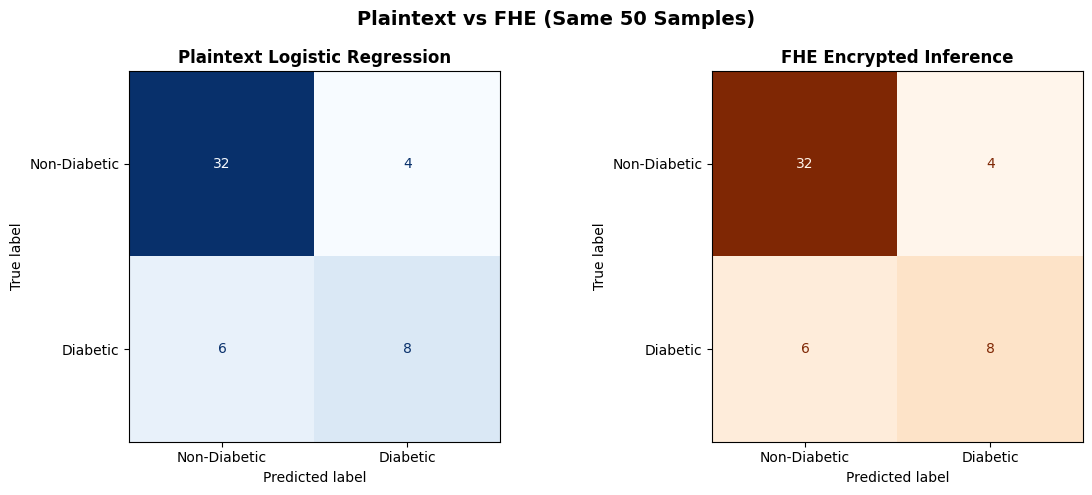


Prediction Agreement: 100.0%


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(metrics_fhe['cm_plain'], display_labels=["Non-Diabetic", "Diabetic"]).plot(
    ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Plaintext Logistic Regression', fontweight='bold')

ConfusionMatrixDisplay(metrics_fhe['cm_fhe'], display_labels=["Non-Diabetic", "Diabetic"]).plot(
    ax=axes[1], cmap='Oranges', colorbar=False)
axes[1].set_title('FHE Encrypted Inference', fontweight='bold')

plt.suptitle('Plaintext vs FHE (Same 50 Samples)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nPrediction Agreement: {metrics_fhe['prediction_agreement']:.1%}")

In [14]:
print("PARAMETER SWEEP EXPERIMENT")
print("\nTesting different FHE configurations\n")

configs = [
    {"name": "Small", "n": 8192, "qi_sizes": [60, 40, 60], "scale": 2**30},
    {"name": "Medium", "n": 16384, "qi_sizes": [60, 40, 40, 60], "scale": 2**30},
    {"name": "Large", "n": 32768, "qi_sizes": [60, 40, 40, 40, 60], "scale": 2**40},
]

sweep_results = []

for cfg in configs:
    print(f"Testing {cfg['name']} configuration (n={cfg['n']})...")
    
    # Initialize FHE with this config
    start = time.time()
    fhe_test = FHEContext(n=cfg['n'], qi_sizes=cfg['qi_sizes'], scale=cfg['scale'])
    kg_time = time.time() - start
    
    # Run evaluation
    metrics = evaluate_fhe_batch(logreg, X_test, y_test, fhe_test, n_samples=20, random_state=42)
    
    sweep_results.append({
        "name": cfg['name'],
        "n": cfg['n'],
        "keygen_time": kg_time,
        "mean_prob_error": metrics['mean_prob_error'],
        "mean_time": metrics['mean_time'],
        "accuracy": metrics['acc_fhe'],
        "agreement": metrics['prediction_agreement']
    })
    
    print(f"   KeyGen: {kg_time:.2f}s | Inference: {metrics['mean_time']:.3f}s | "
          f"Error: {metrics['mean_prob_error']:.2e} | Agreement: {metrics['prediction_agreement']:.1%}")

print("\n Parameter sweep complete!")

PARAMETER SWEEP EXPERIMENT

Testing different FHE configurations

Testing Small configuration (n=8192)...
Evaluating 20 samples...
  Processed 10/20 samples...
  Processed 20/20 samples...
   KeyGen: 0.22s | Inference: 0.024s | Error: 1.53e-07 | Agreement: 100.0%
Testing Medium configuration (n=16384)...
Evaluating 20 samples...
  Processed 10/20 samples...
  Processed 20/20 samples...
   KeyGen: 0.76s | Inference: 0.098s | Error: 4.46e-07 | Agreement: 100.0%
Testing Large configuration (n=32768)...
Evaluating 20 samples...
  Processed 10/20 samples...
  Processed 20/20 samples...
   KeyGen: 2.52s | Inference: 0.277s | Error: 9.13e-10 | Agreement: 100.0%

 Parameter sweep complete!


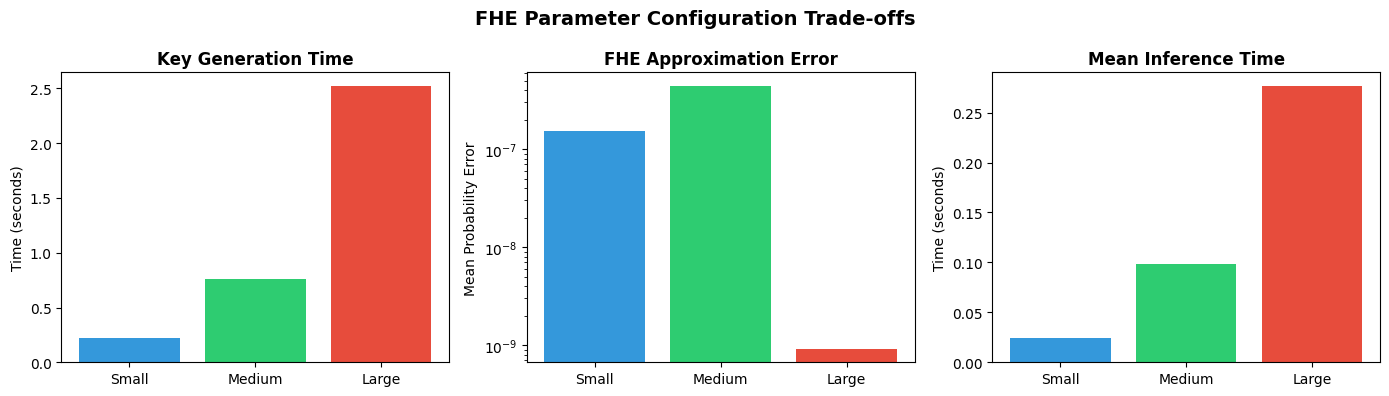

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

names = [r['name'] for r in sweep_results]
colors = ['#3498db', '#2ecc71', '#e74c3c']

# Plot 1: Key Generation Time
vals = [r['keygen_time'] for r in sweep_results]
axes[0].bar(names, vals, color=colors)
axes[0].set_ylabel('Time (seconds)')
axes[0].set_title('Key Generation Time', fontweight='bold')

# Plot 2: Mean Probability Error  
vals = [r['mean_prob_error'] for r in sweep_results]
axes[1].bar(names, vals, color=colors)
axes[1].set_ylabel('Mean Probability Error')
axes[1].set_title('FHE Approximation Error', fontweight='bold')
axes[1].set_yscale('log')

# Plot 3: Mean Inference Time
vals = [r['mean_time'] for r in sweep_results]
axes[2].bar(names, vals, color=colors)
axes[2].set_ylabel('Time (seconds)')
axes[2].set_title('Mean Inference Time', fontweight='bold')

plt.suptitle('FHE Parameter Configuration Trade-offs', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [17]:
# Create a sample patient 
sample_patient_raw = {
    "Pregnancies": 6,
    "Glucose": 148,
    "BloodPressure": 72,
    "SkinThickness": 35,
    "Insulin": 0,
    "BMI": 33.6,
    "DiabetesPedigreeFunction": 0.627,
    "Age": 50
}

print("\nPatient Profile :")
for feature, value in sample_patient_raw.items():
    print(f"   {feature}: {value}")

# Convert to array and standardize
patient_raw = np.array([sample_patient_raw[f] for f in feature_names])
patient_std = scaler.transform(patient_raw.reshape(1, -1)).flatten()

# Initialize server and client
server = FHEServer(logreg, fhe)
client = FHEClient(fhe, bias=server.b)

# Plaintext prediction
z_plain = np.dot(server.w, patient_std) + server.b
prob_plain = 1 / (1 + np.exp(-z_plain))

# FHE prediction
ctxt_patient = client.encrypt_features(patient_std)

ctxt_result = server.encrypted_dot(ctxt_patient)

prob_fhe, pred_fhe = client.decrypt_score_and_predict(ctxt_result)

print(f"\nPlaintext Prediction:")
print(f"   Probability of Diabetes: {prob_plain:.4f} ({prob_plain*100:.1f}%)")
print(f"   Classification: {'DIABETIC' if prob_plain >= 0.5 else 'NON-DIABETIC'}")

print(f"\nFHE Encrypted Prediction:")
print(f"   Probability of Diabetes: {prob_fhe:.4f} ({prob_fhe*100:.1f}%)")
print(f"   Classification: {'DIABETIC' if pred_fhe == 1 else 'NON-DIABETIC'}")

print(f"\nComparison:")
print(f"   Probability Error: {abs(prob_plain - prob_fhe):.6f}")
print(f"   Predictions Match: {'YES' if (prob_plain >= 0.5) == (pred_fhe == 1) else 'NO'}")


Patient Profile :
   Pregnancies: 6
   Glucose: 148
   BloodPressure: 72
   SkinThickness: 35
   Insulin: 0
   BMI: 33.6
   DiabetesPedigreeFunction: 0.627
   Age: 50

Plaintext Prediction:
   Probability of Diabetes: 0.7144 (71.4%)
   Classification: DIABETIC

FHE Encrypted Prediction:
   Probability of Diabetes: 0.7144 (71.4%)
   Classification: DIABETIC

Comparison:
   Probability Error: 0.000000
   Predictions Match: YES


In [18]:
print("\nPLAINTEXT MODEL COMPARISON")
print(f"{'Model':<30} {'Accuracy':<15} {'FHE Compatible'}")
print(f"{'Logistic Regression':<30} {acc_lr:<15.4f} {'Yes'}")
print(f"{'Random Forest':<30} {acc_rf:<15.4f} {'No (branching)'}")

print("\nFHE INFERENCE RESULTS")
print(f"FHE Accuracy:           {metrics_fhe['acc_fhe']:.4f}")
print(f"Plaintext Accuracy:     {metrics_fhe['acc_plain']:.4f}")
print(f"Mean Probability Error: {metrics_fhe['mean_prob_error']:.6f}")
print(f"Prediction Agreement:   {metrics_fhe['prediction_agreement']:.1%}")
print(f"Mean Inference Time:    {metrics_fhe['mean_time']:.4f}s")

print("\nPARAMETER CONFIGURATION COMPARISON")
print(f"{'Config':<10} {'Poly Degree':<12} {'KeyGen (s)':<12} {'Inference (s)':<15} {'Agreement'}")
for r in sweep_results:
    print(f"{r['name']:<10} {r['n']:<12} {r['keygen_time']:<12.2f} {r['mean_time']:<15.4f} {r['agreement']:.1%}")


PLAINTEXT MODEL COMPARISON
Model                          Accuracy        FHE Compatible
Logistic Regression            0.7527          Yes
Random Forest                  0.9964          No (branching)

FHE INFERENCE RESULTS
FHE Accuracy:           0.8000
Plaintext Accuracy:     0.8000
Mean Probability Error: 0.000000
Prediction Agreement:   100.0%
Mean Inference Time:    0.0878s

PARAMETER CONFIGURATION COMPARISON
Config     Poly Degree  KeyGen (s)   Inference (s)   Agreement
Small      8192         0.22         0.0243          100.0%
Medium     16384        0.76         0.0984          100.0%
Large      32768        2.52         0.2765          100.0%
